In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os
import random
import scipy
import matplotlib.pyplot as plt
import scvelo as scv
import networkx as nx
import anndata as ad
import cellrank as cr
import scanpy as sc



In [ ]:
subsets = glob.glob('../../labelled/*subset*') ##find the subsets of the data generated using r
#scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo',dpi = 200)  # for beautified visualization

: 

## load in the datasets

In [ ]:
wt_all =scv.read('../../labelled/all_info/chan_wt_dynamical_trimmed.h5ad')
mut_all =scv.read('../../labelled/all_info/chan_mut_dynamical_trimmed.h5ad')

#mut_all_stoch =scv.read('../../labelled/all_info/chan_mut_trimmed.h5ad')


#wt_all_stoch =scv.read('../../labelled/all_info/chan_wt_loom_trimmed.h5ad')

#wt_test =scv.read('../../labelled/all_info/chan_mut_PAX6.h5ad')

#wt_all_genes = scv.read('../../labelled/all_info/chan_wt.h5ad')


#del(wt_all)
#wt_PAX6.write
#mut_all = scv.read('../../labelled/all_info/chan_mut.h5ad')

: 

# 2. explore the datasets
    1. find the basic propotions of the spliced and unspliced
    2. Look at the velocity in the overall UMAP


In [ ]:
scv.pl.proportions(wt_all,groupby='cluster')
plt.show()
scv.pl.proportions(mut_all,groupby='cluster')



: 

In [ ]:
conds = ['mut','wt'] ##write a list of strigs - the names of the conditons
for cond_i, cond in enumerate([mut_all,wt_all]): ##do for both wt and mutant
    largest = cond.var.fit_r2.nlargest(2)
    smallest = cond.var.fit_r2.nsmallest(2)
    scv.pl.velocity(cond, var_names = smallest.index, color='cluster',dpi = 200,save=f'../../plots/worst_fits_{conds[cond_i]}_r2_{smallest.values}.pdf') #plot and save the worst fitting genes
    scv.pl.velocity(cond, var_names = largest.index, color='cluster',dpi = 200,save=f'../../plots/best_fits_{conds[cond_i]}_r2_{largest.values}.pdf') #plot and save the best fitting genes
                                    
                                    #'EIF4G2','TMEM256'], color='cluster',dpi = 200)

: 

In [ ]:
df = mut_all.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(mut_all, 'fit*', dropna=True).head()

: 

: 

## pseudotime along the graph

Calculated based off diffusion along the velocity graph. Originally the method was used to indentify the branching points of the pseudotemporal ordering graph based of expression similarity. Here however, we use the scVelo velocity graoh which captures the dynamics of the gene expression more precisely. We caluculate velocity pseudotime as opposed to the expression similarity.

We start by subsetting the data into the main pathways ideintified in the paper. We plot the results.



In [ ]:
pathway1_cells = ['RGP1','RGP2','RGP3','IN Progenitor','IN1','IP','EN','DLN','SLN']

mut_path1 = mut_all[mut_all.obs.cluster.isin(pathway1_cells)]
wt_path1 = wt_all[wt_all.obs.cluster.isin(pathway1_cells)]

mut_path2 = mut_all[~mut_all.obs.cluster.isin(pathway1_cells)]
wt_path2 = wt_all[~wt_all.obs.cluster.isin(pathway1_cells)]

with scv.GridSpec(ncols=4) as pl:
    pl.scatter(mut_path1, color='cluster', color_map='gnuplot',title='Mutant subset 1')
    pl.scatter(wt_path1, color='cluster', color_map='gnuplot',title='Wt subset 1')
    pl.scatter(mut_path2, color='cluster', color_map='gnuplot',title='Mutant subset 2')
    pl.scatter(wt_path2, color='cluster', color_map='gnuplot',title='Wt subset 2')
    


: 

Now calculate the latent time across the subsets - we need to recompute the dynamics all together:(

In [ ]:
subsets = [wt_path1,mut_path1] #choose the subsets to be analysed

for subset in subsets: #loop for any subsets needed
    scv.pp.filter_and_normalize(subset, min_shared_counts=20)
    scv.pp.neighbors(subset)
    scv.pp.moments(subset) ##moments
    scv.tl.recover_dynamics(subset,n_jobs = -2)

    scv.tl.velocity(subset, mode='dynamical',n_jobs = -2)
    scv.tl.velocity_graph(subset,n_jobs = -2)
    scv.tl.latent_time(subset)


with scv.GridSpec(ncols=len(subsets)) as pl:
    for subset in subsets:
        pl.scatter(subset, color='latent_time', color_map='gnuplot', size=10,dpi = 300,title=f'{subset} latent time')

    #pl.scatter(wt_all[wt_all.obs.cluster.isin(pathway1_cells)], color='latent_time', color_map='gnuplot', size=10,dpi =300)




: 

## plot the results - still using scv

In [ ]:
subset_names = ['wt_path1','mut_path1']

scv.settings.set_figure_params(
    frameon=False,
    dpi=200,
)

with scv.GridSpec(ncols=len(subsets)) as pl:
    for subset_i,subset in enumerate(subsets):
        pl.scatter(subset, color='latent_time', color_map='gnuplot', size=10,dpi = 400,title=f'{subset_names[subset_i]} latent time')

with scv.GridSpec(ncols=len(subsets)) as pl:
    for subset_i,subset in enumerate(subsets):
        pl.scatter(subset, color='root_cells', color_map='gnuplot', size=10,dpi = 400,title=f'{subset_names[subset_i]} root cells')

with scv.GridSpec(ncols=len(subsets)) as pl:
    for subset_i,subset in enumerate(subsets):
        pl.scatter(subset, color='end_points', color_map='gnuplot', size=10,dpi = 400,title=f'{subset_names[subset_i]} end points')

with scv.GridSpec(ncols=len(subsets)) as pl:
    for subset_i,subset in enumerate(subsets):
        pl.scatter(subset, color='cluster', color_map='gnuplot', size=10,dpi = 400,title=f'{subset_names[subset_i]} clusters')

: 

In [ ]:

for subset_i,subset in enumerate(subsets):
    sc.pl.embedding(subset, basis="umap", color=["cluster",'latent_time'],title=f'{subset_names[subset_i]}')




: 

In [ ]:


for subset in subsets:
        scv.pl.proportions(subset,groupby= 'cluster') ##just to check the new subsets

: 

## Computing the kernels
here we compute the kernels for both wildtype and mutant cells

In [4]:
subsets = []
subset_names = ['wt_path1','mut_path1']

for m in range(2):
        print(m)
        subsets.append(scv.read('../../labelled/all_info/chan_mut_dynamical_trimmed.h5ad'))



kernels = []
for subset_i,subset in enumerate(subsets):
    kernels.append(cr.kernels.VelocityKernel(subset))


result = dict(zip(subset_names, kernels))


0
1


In [ ]:
for kernel in kernels:
    kernel.compute_transition_matrix()
    

: 

save the kernels to datafiles

In [ ]:
for kernel_i, kernel in enumerate(kernels):
    kernel.write_to_adata()
    subsets[kernel_i].write(f'../../labelled/all_info/{subset_names[kernel_i]}_trimmed_with_vk_kernel.h5ad',compression="gzip") ##change this ! These files only have the path1 subset !!! Careful !!
   
    

scv.read('../../labelled/all_info/{subset_names[kernel_i]}_trimmed_with_vk_kernel.h5ad')

: 

In [2]:
subsets = [] ##cell to run from the start run_start_vk
subset_names = ['wt_path1','mut_path1']
subsets.append(scv.read('../../labelled/all_info/wt_path1_trimmed_with_vk_kernel.h5ad'))
subsets.append(scv.read('../../labelled/all_info/mut_path1_trimmed_with_vk_kernel.h5ad'))
data_all = dict(zip(subset_names, subsets))



In [3]:
kernels = []
for subset in subsets:
    kernels.append(cr.kernels.VelocityKernel.from_adata(subset,key = 'T_fwd'))

In [4]:
estimators = []
for subset_i, subset in enumerate(subsets):
    #sc.pl.embedding(subset, basis="umap", color="cluster")
    estimators.append(cr.estimators.GPCCA(kernels[subset_i]))

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


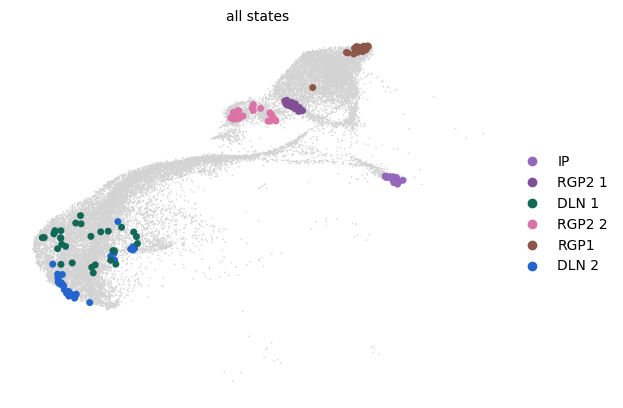

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


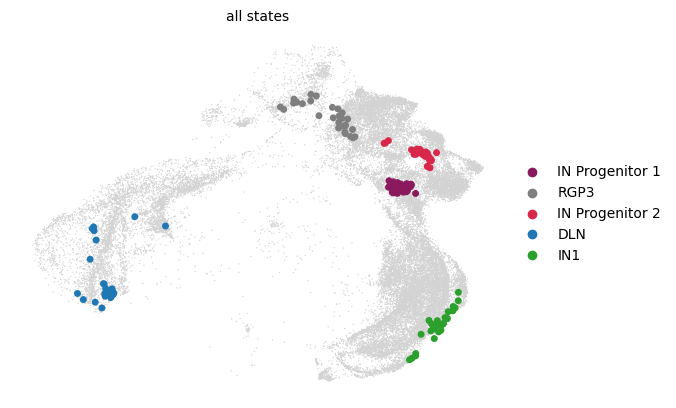

In [27]:
for estimator in estimators:
    estimator.fit(cluster_key="cluster", n_states= [4,12])
    estimator.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)


# compute the initial and terminal states

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


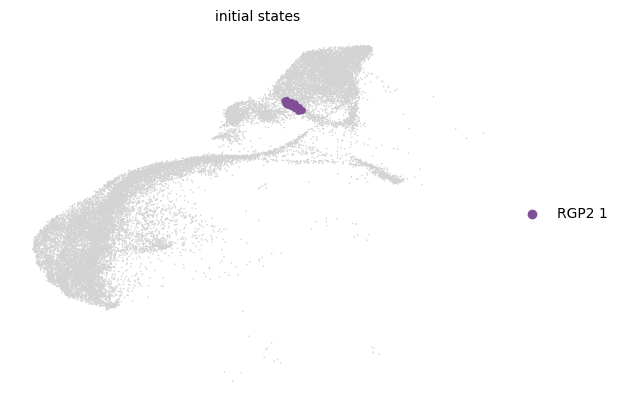

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


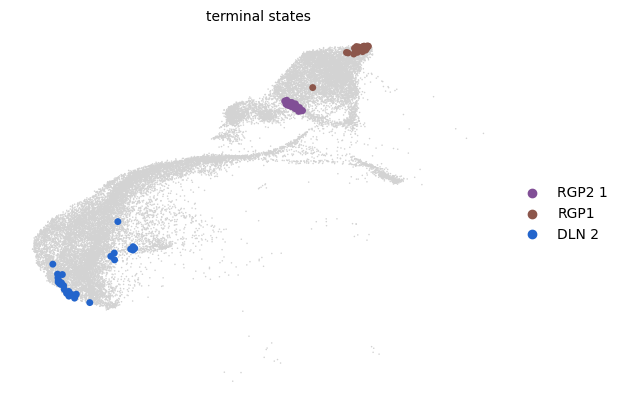

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


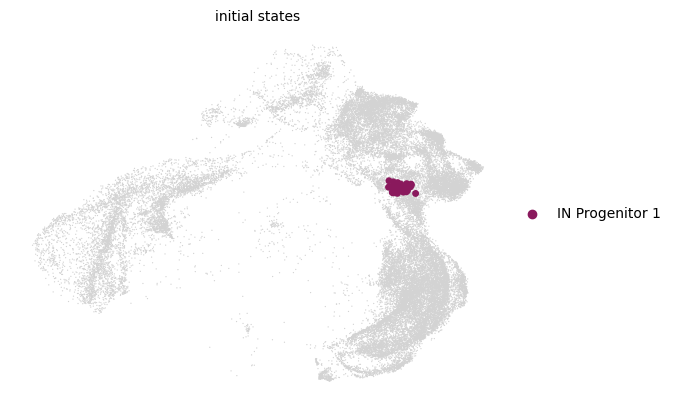

/Users/samuelheczko/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


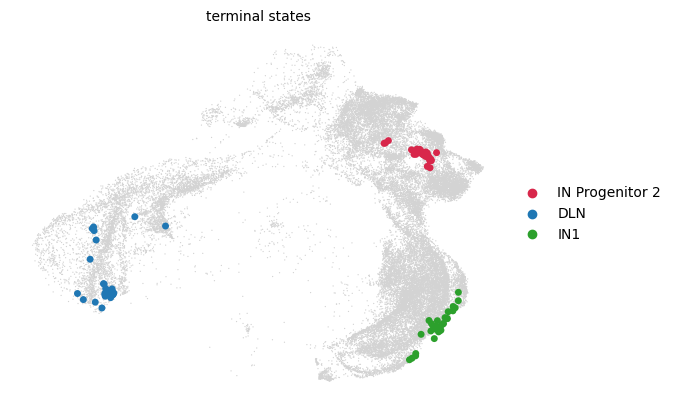

In [28]:
for estimator in estimators:
    estimator.predict_terminal_states(allow_overlap=True)
    estimator.predict_initial_states(allow_overlap=True)
    estimator.plot_macrostates(which="initial", legend_loc="right", s=100)
    estimator.plot_macrostates(which="terminal", legend_loc="right", s=100)

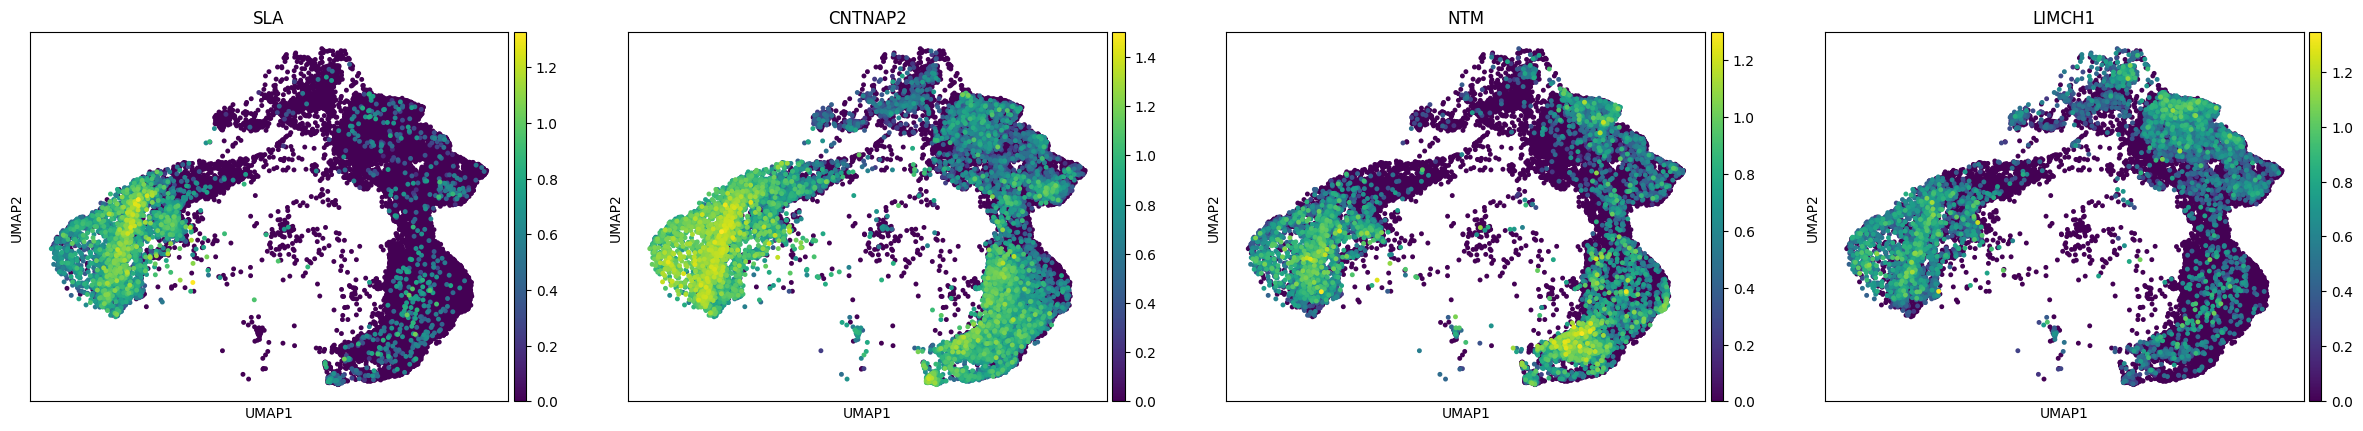

In [15]:
mature_genes = ["SLA",'CNTNAP2','NTM','LIMCH1'] ##from braum et al 2023, Comprehensive cell atlas of the first-trimesterdeveloping human brain
sc.pl.embedding(
    subsets[1],
    basis="umap",
    color=mature_genes,
    size=50,
)

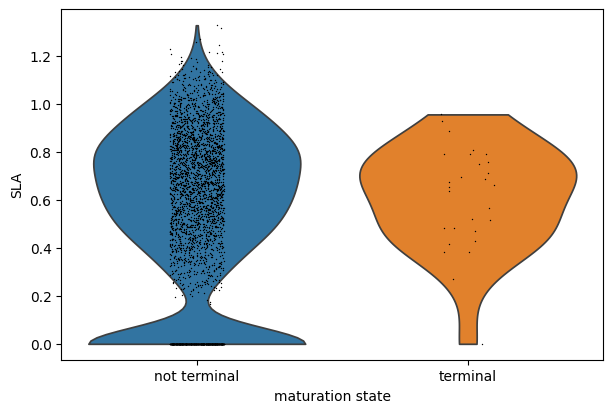

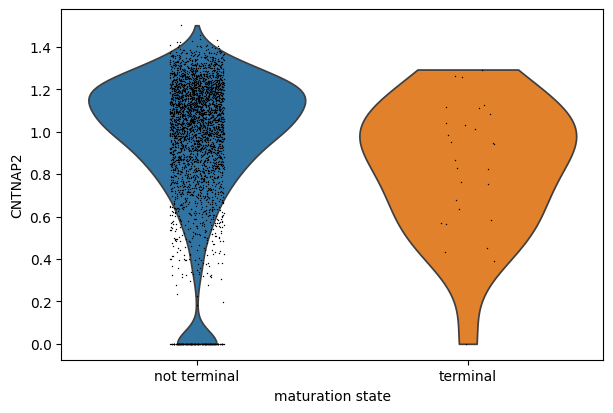

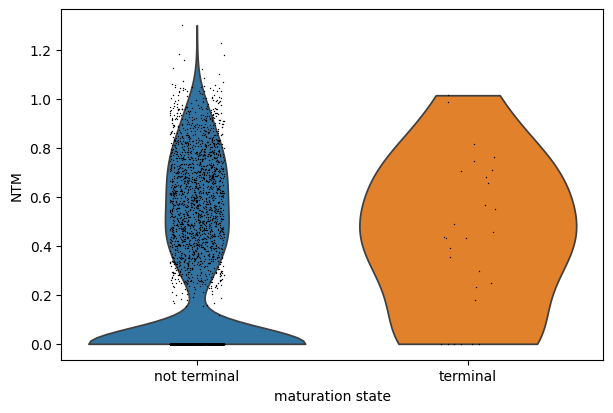

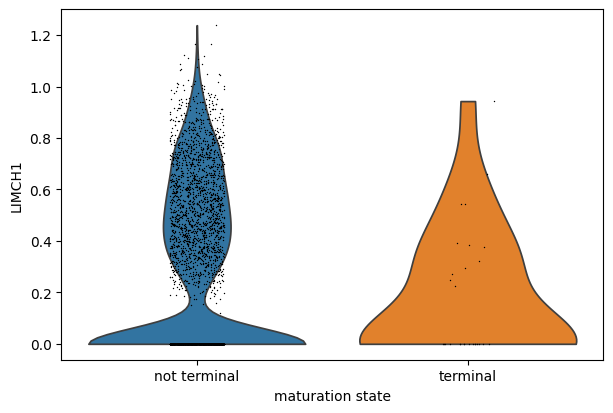

In [23]:
genes = []

import scipy.stats as st
for gene in mature_genes:
    # subset to just Beta cells
    bdata = subsets[1][subsets[1].obs["cluster"] == "DLN"].copy()

    # create an annotation for terminal vs. not-terminal
    bdata.obs["maturation_state"] = np.where(
        bdata.obs["term_states_fwd"] == "DLN", "terminal", "not terminal"
    )

    # show distribution in violin plot
    sc.pl.violin(bdata, keys=gene, groupby="maturation_state")

    # use a simple t-test to quantify how different the two distributions are
    a = bdata[bdata.obs["maturation_state"] == "terminal", gene].X.data
    b = bdata[bdata.obs["maturation_state"] == "not terminal", gene].X.data
    st.ttest_ind(a, b, equal_var=False)

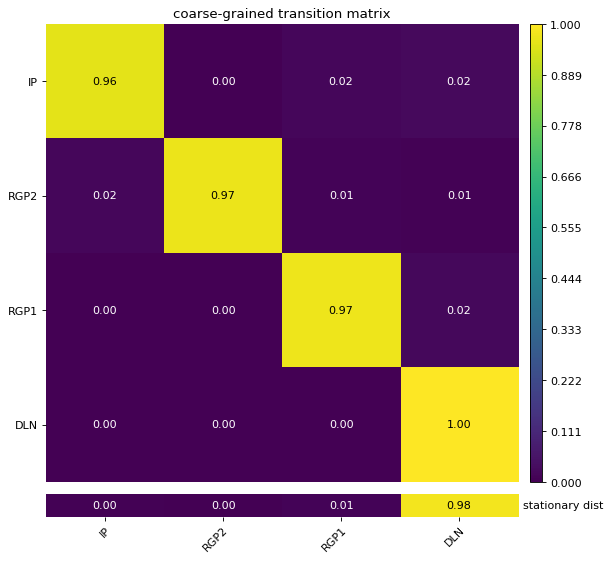

In [25]:
estimators[0].plot_coarse_T()

  0%|          | 0/3 [00:00<?, ?/s]

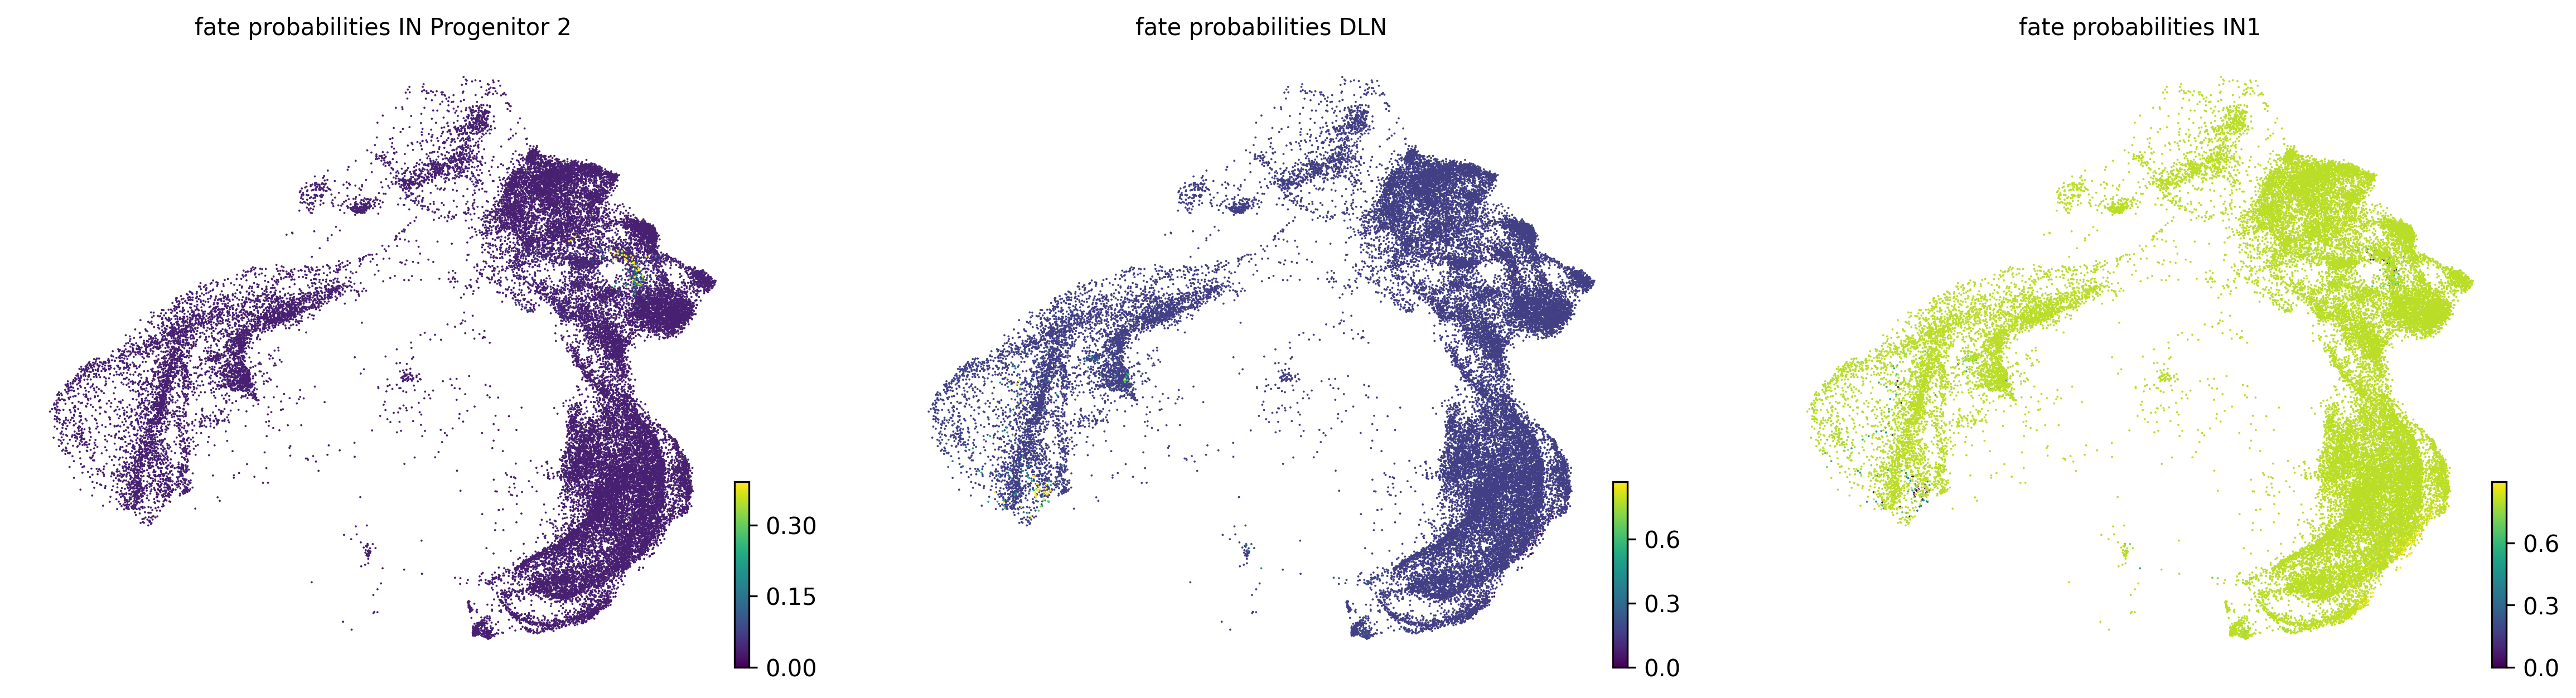

In [66]:
#estimators[1].set_terminal_states(states=["DLN",'IN1','IN pro'])
#cr.logging.print_versions()
estimators[1].compute_fate_probabilities()

estimators[1].plot_fate_probabilities(same_plot=False,dpi = 300)


/Users/samuelheczko/anaconda3/envs/scvelo/lib/python3.11/site-packages/cellrank/pl/_circular_projection.py:226: ImplicitModificationWarning: Setting element `.obsm['X_fate_simplex_fwd']` of view, initializing view as actual.
  adata.obsm[key_added] = np.c_[x, y]


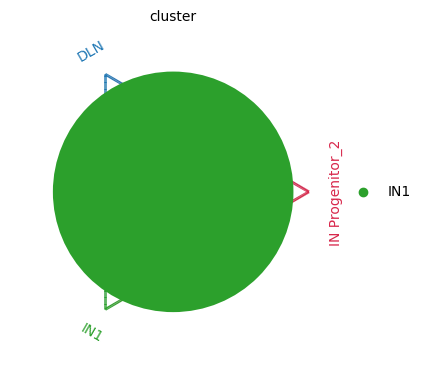

In [65]:
cr.pl.circular_projection(subset[1], keys=["cluster"], legend_loc="right")



In [59]:
delta_df = estimators[1].compute_lineage_drivers(
    lineages=['IN1',"IN Progenitor_2",'DLN'], cluster_key="cluster")
delta_df.head(10)


IN1_corr      IN1_pval      IN1_qval  IN1_ci_low  IN1_ci_high  \
Gene                                                                      
DLX6-AS1  0.073176  6.268030e-44  5.253749e-42    0.062888     0.083449   
DLX5      0.065137  3.849838e-35  2.366367e-33    0.054838     0.075421   
GAD2      0.060783  8.276477e-31  3.736027e-29    0.050479     0.071074   
SP9       0.059709  8.728381e-30  3.576697e-28    0.049404     0.070002   
TMEM123   0.057545  8.861462e-28  3.268107e-26    0.047237     0.067840   
DCLK2     0.054517  4.271163e-25  1.334919e-23    0.044207     0.064817   
MIR9-1HG  0.053633  2.439981e-24  7.110312e-23    0.043321     0.063933   
ARX       0.051973  5.957464e-23  1.547263e-21    0.041659     0.062275   
RND3      0.050567  8.241569e-22  2.026327e-20    0.040252     0.060871   
DCX       0.049397  6.958071e-21  1.545865e-19    0.039081     0.059702   

          IN Progenitor_2_corr  IN Progenitor_2_pval  IN Progenitor_2_qval  \
Gene                                                                         
DLX6-AS1             -0.049013          1.386050e-20          1.435886e-19   
DLX5                 -0.043314          2.059301e-16          1.588849e-15   
GAD2                 -0.038288          3.764560e-13          2.239306e-12   
SP9                  -0.036022          8.282251e-12          4.290020e-11   
TMEM123               0.002849          5.890593e-01          6.315264e-01   
DCLK2                -0.034642          4.982246e-11          2.436939e-10   
MIR9-1HG             -0.020540          9.806919e-05          2.309573e-04   
ARX                  -0.012527          1.752520e-02          2.785486e-02   
RND3                 -0.015459          3.372635e-03          6.225364e-03   
DCX                  -0.093188          2.838218e-70          6.542093e-68   

          IN Progenitor_2_ci_low  IN Progenitor_2_ci_high  DLN_corr  \
Gene                                                                  
DLX6-AS1               -0.059318                -0.038697 -0.043878   
DLX5                   -0.053626                -0.032994 -0.039359   
GAD2                   -0.048604                -0.027963 -0.038784   
SP9                    -0.046341                -0.025696 -0.039631   
TMEM123                -0.007487                 0.013184 -0.074374   
DCLK2                  -0.044961                -0.024314 -0.034491   
MIR9-1HG               -0.030869                -0.010206 -0.046977   
ARX                    -0.022860                -0.002191 -0.052630   
RND3                   -0.025790                -0.005124 -0.048054   
DCX                    -0.103424                -0.082932  0.028278   

              DLN_pval      DLN_qval  DLN_ci_low  DLN_ci_high  
Gene                                                           
DLX6-AS1  8.387412e-17  5.814432e-16   -0.054189    -0.033558  
DLX5      8.185037e-14  4.559882e-13   -0.049675    -0.029035  
GAD2      1.866384e-13  1.006320e-12   -0.049100    -0.028460  
SP9       5.522346e-14  3.152695e-13   -0.049946    -0.029307  
TMEM123   2.514204e-45  5.653894e-44   -0.084644    -0.064087  
DCLK2     6.036829e-11  2.613125e-10   -0.044810    -0.024164  
MIR9-1HG  4.900215e-19  3.845105e-18   -0.057285    -0.036659  
ARX       1.702622e-23  1.687976e-22   -0.062931    -0.042317  
RND3      7.574333e-20  6.125908e-19   -0.058360    -0.037737  
DCX       8.155914e-08  2.465493e-07    0.017948     0.038603

In [64]:
cr.pl.aggregate_fate_probabilities(
    subset[1],
    mode="violin",
    lineages=["IN1"],
    cluster_key="cluster",
    clusters=['IN1','DLN'],
)

KeyError: "Cluster `'DLN'` not found in `adata.obs['cluster']`."

In [52]:
estimators[1].fate_probabilities["DLN"].X.flatten().std()

0.030159462558997843

In [ ]:
np.sum(wt_all[:,wt_all.var.velocity_genes == True].var.isna())

: 

In [ ]:
wt_all[:,wt_all.var.dropna().index].var


##0 load the whole dataset
#adata = scv.read('../../chan_wt.h5ad')
##1 save the subset of genes where the velocity was calculated of the data - the h5ad is fine as the feature space is so much smaller
#wt_all[:,wt_all.var.velocity_genes == True].write('../../labelled/all_info/chan_wt_loom_trimmed.h5ad')()

np.sum(wt_all[:,wt_all.var.velocity_genes == True].var_names == 'PAX6')


: 

In [ ]:
print(wt_all.var_names != (wt_all.var.dropna().index))

print(wt_all.var.dropna().index.shape)

: 

In [ ]:
#wt_PAX6 = wt_all[wt_all.var.loc == ['PAX6']]
#wt_all.uns['velocity_graph']
#G = nx.from_scipy_sparse_array(wt_all.uns['velocity_graph'])
nx.draw_networkx(G,node_size = 10)

: 

test of scVelo

In [ ]:
wt_all.X ##acess the sparse matrix

#wt_all[wt_all.var.columns == 'PAX6']##get the gene name
wt_all[wt_all.var.loc == ['PAX6']]##subset the PAX6 data


#print(wt_all.obs_names)

#wt_all[['19071MJpool03__1:AAACCCACAATCCTTTx'],['PAX6']]
#print(pd.Categorical(['PAX6','test']))
#(sc_velo_loom.obs.cluster == 'NEP')


: 

In [ ]:
##preprocess 

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000) ##fitler and normalise
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) ##find the spliced/unslpliced ratios

: 

In [ ]:
scv.tl.recover_dynamics(adata,n_jobs = -1)


: 

In [ ]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata,n_jobs = -2)

: 

In [ ]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

: 

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')


: 

In [ ]:
def take_random_subset(df,samples = 100, seed = 0):
    random.seed(seed)
    if samples > df.shape[0]:
        samples = df.shape[0]
    return(df.iloc[random.sample(range(df.shape[0]), samples),:])

: 

In [ ]:
df_list = [] ##list of dataframes to which the rest will be appended
atribs_list = []
for subset in subsets: ## loop over the subesets of the data
    df = (pd.read_csv(subset,index_col=0)).T
    #print(subset)
    atribs = subset.split('.')[-2].split('_')[-2:]
    atribs_list.append(atribs) # every entry on the list must have condition and then cell type
    df["condition"] =  atribs[0]
    df["cell_type"] =  atribs[1]

    df_list.append(df)

df_concat = pd.concat(df_list)




: 

In [ ]:
rand_subset_w = take_random_subset(df = df_concat[(df_concat['cell_type'] == 'IP') & (df_concat['condition'] == 'Wildtype')],samples = 100, seed = 0)
rand_subset_m = take_random_subset(df = df_concat[(df_concat['cell_type'] == 'IP') & (df_concat['condition'] == 'Mutant')],samples = 100, seed = 0)

df_concat_ip_rand = pd.concat([rand_subset_m,rand_subset_w])


: 

In [ ]:
rand_subset_list = []
for atrib in atribs_list:
    rand_subset_list.append(take_random_subset(df = df_concat[(df_concat['cell_type'] == atrib[1]) & (df_concat['condition'] == atrib[0])],samples = 40, seed = 0))


: 

In [ ]:

sns.violinplot(data = pd.concat(rand_subset_list), x = 'cell_type', y = 'PAX6' ,hue = 'condition',kind = 'violin',split=True)



: 

In [ ]:
sns.catplot(data = df_concat, x = 'cell_type', y = 'PAX6' ,hue = 'condition',kind = 'swarm')


: 

In [ ]:
(df_concat[(df_concat['cell_type'] == 'IN Progenitor') & (df_concat['condition'] == 'Wildtype')]).corrwith(df_concat[(df_concat['cell_type'] == 'IN Progenitor') & (df_concat['condition'] == 'Mutant')],axis = 1)

: 

In [ ]:
dataframes = {}
joined_atribs = ['_'.join(inner_list) for inner_list in atribs_list]
for name_i, name in enumerate(joined_atribs):
    dataframes[name] = df_list[name_i]

: 

In [ ]:
(dataframes['Wildtype_RGP1']).drop(['cell_type','condition'],axis = 1).values.shape

: 

In [ ]:
np.corrcoef(x = np.average((dataframes['Mutant_DLN']).drop(['cell_type','condition'],axis = 1).values,axis = 0), y = (dataframes['Mutant_RGP1']).drop(['cell_type','condition'],axis = 1).values).shape

: 

In [ ]:
corr = scipy.signal.correlate((dataframes['Mutant_DLN']).drop(['cell_type','condition'],axis = 1).values,(dataframes['Mutant_RGP1']).drop(['cell_type','condition'],axis = 1).values)

: 

In [ ]:
mutant_cells_DLN = (dataframes['Mutant_DLN']).drop(['cell_type','condition'],axis = 1).values
mutant_cells_RGP1 = (dataframes['Mutant_RGP1']).drop(['cell_type','condition'],axis = 1).values
mutant_cells_comb = np.vstack([mutant_cells_RGP1,mutant_cells_DLN])
corr_mutant_RGP1 = np.corrcoef(mutant_cells_comb)

distance = np.linalg.norm(mutant_cells_comb)

: 

In [ ]:
corr_mutant_RGP1_copy = corr_mutant_RGP1
corr_mutant_RGP1_copy[:RPG_amopunt,RPG_amopunt:] = 0

plt.imshow(corr_mutant_RGP1)
plt.colorbar()
plt.show()


: 

In [ ]:
mutant_cells_comb.shape

: 

In [ ]:
RPG_amopunt = mutant_cells_RGP1.shape[0]
DLN_amopunt = mutant_cells_DLN.shape[0]

: 

In [ ]:
plt.hist(corr_mutant_RGP1[:RPG_amopunt,RPG_amopunt:].flatten(),bins = 100)

: 

In [ ]:
top_2_idx = np.argsort(corr_mutant_RGP1[:RPG_amopunt,RPG_amopunt:])[-2:]


: 

In [ ]:
top_2_idx.shape

: 

In [ ]:
corr_mutant_RGP1[:RPG_amopunt,RPG_amopunt:].shape

: 

In [ ]:
sc_velo_loom = scv.read('../../labelled/chan_wt.h5ad')

: 

In [ ]:
sc_velo_loom.obs.cluster

: 

In [ ]:
scv.pp.filter_and_normalize(sc_velo_loom, min_shared_counts=20, n_top_genes=2000)


: 

In [ ]:
scv.pp.moments(sc_velo_loom, n_pcs=30, n_neighbors=30)

: 

In [ ]:
scv.tl.recover_dynamics(sc_velo_loom,n_jobs=-1)
#scv.tl.velocity(sc_velo_loom, n_jobs=-1,mode='stochastic')

#scv.tl.velocity_graph(sc_velo_loom, n_jobs=-1)



: 

: 

: 

In [ ]:
#scv.pl.velocity_embedding_stream(sc_velo_loom, basis='umap')
scv.tl.velocity_confidence(sc_velo_loom)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(sc_velo_loom, c=keys, cmap='coolwarm', perc=[5, 95])

: 

In [ ]:
#scv.pl.velocity_embedding_stream(sc_velo_loom, basis='umap',color = 'cluster')
#scv.utils.get_cell_transitions(sc_velo_loom, basis='umap', starting_cell=70).shape





scv.pl.velocity_graph(sc_velo_loom, threshold=0.1,color = 'cluster')


: 

In [ ]:
sc_velo_loom[sc_velo_loom.obs.cluster == 'DLN'] ##take subset

: 

In [ ]:
scv.pl.velocity(sc_velo_loom['RGP1', :], ['PAX6'], ncols=2,color = 'cluster',dpi = 300)



: 

In [ ]:
scv.pl.scatter(sc_velo_loom[(sc_velo_loom.obs.cluster == 'NEP') | (sc_velo_loom.obs.cluster == 'RGP1')] , ['PAX6'], color=['cluster', 'velocity'],color_map='Pastel1')

: 

In [ ]:
scv.pl.proportions(sc_velo_loom,groupby='cluster')

: 

In [ ]:
(sc_velo_loom.obs.cluster == 'NEP') | (sc_velo_loom.obs.cluster == 'RGP1')

: 

: 